In [57]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import string
import unicodedata

!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

ssttrainxs, ssttrainys = loadsst("./data/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("./data/trees/dev.txt")
ssttestxs, ssttestys = loadsst("./data/trees/test.txt")

all_letters = string.ascii_letters + ' .,;:\'-#!/"=&$|_'
n_letters = len(all_letters)

# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def normalize(string):
    for i in range(len(string)):
        replacements = [(" ,", ","), (" .", "."), (" '", "'"), 
                        ("\/", "/"), (" ;", ";"), (" :", ":"),
                        (" %", "%"), (u"æ", "ae"), (u"Æ", "AE"), 
                        (u"œ", "oe"), (u"Œ", "OE"), ("-LRB- ", "("), 
                        (" -RRB-", ")"), ("-LRB-", "("), ("-RRB-", ")"),
                        (" n't", "n't"), ("`` ", '"'), ("``", '"'),
                        ("''", '"'), ("` ", "'"), ("$ ", "$"),
                        (" !", "!"), ("\\", "")]
        for to_replace, replacement in replacements:
            string = string.replace(to_replace, replacement)
    return unicodeToAscii(string)

def get_normalized_dataset(dataset):
    return [normalize(" ".join(sentence)) for sentence in dataset]

trainxs_corpus = "_".join(get_normalized_dataset(ssttrainxs))
validxs_corpus = "_".join(get_normalized_dataset(sstvalidxs))
testxs_corpus = "_".join(get_normalized_dataset(ssttestxs))

seq_len = 200

corpus_to_ss = lambda corpus: [corpus[(i*200):((i+1)*200)] for i in range(len(corpus) // seq_len)]
trainxs_sentences = corpus_to_ss(trainxs_corpus)

In [6]:
vocab = sorted(list(set(trainxs_corpus)))
n_sentences, vocab_size = len(trainxs_sentences), len(vocab)
maxlen = len(max(trainxs_sentences, key=len))
char_to_idx = { ch:idx for idx,ch in enumerate(vocab) }
idx_to_char = { idx:ch for idx,ch in enumerate(vocab) }
print("{} sentences, {} letters in vocab, max seq len is {}".format(n_sentences, vocab_size, maxlen))

4292 sentences, 67 letters in vocab, max seq len is 200


In [7]:
def pad_inputs(sentences, maxlen):
    for i in range(len(sentences)):
        while len(sentences[i]) < maxlen:
            sentences[i] += ' '
    return sentences
trainxs = pad_inputs(trainxs_sentences, maxlen)

In [8]:
def get_input_target(ss):
    """Get input and target from padded sentences"""
    input_ss = []
    target_ss = []
    for i in range(len(ss)):
        input_ss.append([char_to_idx[c] for c in ss[i][:-1]])
        target_ss.append([char_to_idx[c] for c in ss[i][1:]])
    return input_ss, target_ss
input_ss, target_ss = get_input_target(trainxs)

In [9]:
print(input_ss[0])
print(target_ss[0])

[33, 48, 45, 0, 31, 55, 43, 51, 0, 49, 59, 0, 44, 45, 59, 60, 49, 54, 45, 44, 0, 60, 55, 0, 42, 45, 0, 60, 48, 45, 0, 59, 60, 0, 16, 45, 54, 60, 61, 58, 65, 6, 59, 0, 54, 45, 63, 0, 2, 16, 55, 54, 41, 54, 2, 0, 41, 54, 44, 0, 60, 48, 41, 60, 0, 48, 45, 6, 59, 0, 47, 55, 49, 54, 47, 0, 60, 55, 0, 53, 41, 51, 45, 0, 41, 0, 59, 56, 52, 41, 59, 48, 0, 45, 62, 45, 54, 0, 47, 58, 45, 41, 60, 45, 58, 0, 60, 48, 41, 54, 0, 14, 58, 54, 55, 52, 44, 0, 32, 43, 48, 63, 41, 58, 66, 45, 54, 45, 47, 47, 45, 58, 7, 0, 23, 45, 41, 54, 8, 16, 52, 41, 61, 44, 0, 35, 41, 54, 0, 17, 41, 53, 53, 45, 0, 55, 58, 0, 32, 60, 45, 62, 45, 54, 0, 32, 45, 47, 41, 52, 9, 40, 33, 48, 45, 0, 47, 55, 58, 47, 45, 55, 61, 59, 52, 65, 0, 45, 52, 41, 42, 55, 58, 41, 60, 45, 0, 43, 55]
[48, 45, 0, 31, 55, 43, 51, 0, 49, 59, 0, 44, 45, 59, 60, 49, 54, 45, 44, 0, 60, 55, 0, 42, 45, 0, 60, 48, 45, 0, 59, 60, 0, 16, 45, 54, 60, 61, 58, 65, 6, 59, 0, 54, 45, 63, 0, 2, 16, 55, 54, 41, 54, 2, 0, 41, 54, 44, 0, 60, 48, 41, 60, 0, 4

In [10]:
# Hyperparameters
seq_len = maxlen - 1
batch_size = n_sentences
n_epochs = 200
lr = 0.01

In [11]:
def one_hot_encode(ss, vocab_size, seq_len, batch_size):
    tensor = torch.zeros(batch_size, seq_len, vocab_size)
    for i in range(batch_size):
        for j in range(seq_len):
            tensor[i, j, ss[i][j]] = 1
    return tensor

In [12]:
input_ohe = one_hot_encode(input_ss, vocab_size, seq_len, batch_size)
target_tensor = torch.Tensor(target_ss) # No OHE necessary

In [13]:
# device = torch.device("cpu")
# if torch.cuda.is_available: device = torch.device("cuda")

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # define Layers
        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        batch_size = input.size(0)
        
        # Init hidden state for first input
        hidden = self.init_hidden(batch_size)
        
        # pass input and hidden state into the model
        output, hidden = self.rnn(input, hidden)
        
        # reshape outputs so it can pass into fc layer
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [15]:
rnn = RNN(input_size=vocab_size, output_size=vocab_size, hidden_size=23)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=lr)

In [18]:
# Training Run
loss_ary = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    
    output, hidden = rnn(input_ohe)
    loss = criterion(output, target_tensor.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
    loss_ary.append(loss)

Epoch: 10/200............. Loss: 3.1532
Epoch: 20/200............. Loss: 3.1122
Epoch: 30/200............. Loss: 3.0791
Epoch: 40/200............. Loss: 3.0236
Epoch: 50/200............. Loss: 2.9526
Epoch: 60/200............. Loss: 2.8553
Epoch: 70/200............. Loss: 2.7548
Epoch: 80/200............. Loss: 2.6610
Epoch: 90/200............. Loss: 2.5838
Epoch: 100/200............. Loss: 2.5232
Epoch: 110/200............. Loss: 2.4751
Epoch: 120/200............. Loss: 2.4362
Epoch: 130/200............. Loss: 2.4026
Epoch: 140/200............. Loss: 2.3741
Epoch: 150/200............. Loss: 2.3497
Epoch: 160/200............. Loss: 2.3295
Epoch: 170/200............. Loss: 2.3121
Epoch: 180/200............. Loss: 2.2967
Epoch: 190/200............. Loss: 2.2824
Epoch: 200/200............. Loss: 2.2691


In [49]:
def sample_idx_from_prob(prob):
    idx = prob.multinomial(num_samples=1, replacement=True)
    return idx.item()

def predict(model, s):
    s = np.array([[char_to_idx[c] for c in s]])
    s_ohe = one_hot_encode(s, vocab_size, s.shape[1], 1)
    
    out, _ = model(s_ohe)

    prob = F.softmax(out[-1], dim=0)
#     print(prob)
#     print(prob.data)

#     out_idx = torch.max(prob, dim=0)[1].item()
    out_idx = sample_idx_from_prob(prob)

    return idx_to_char[out_idx], hidden

In [50]:
# This function takes the desired output length and input characters as arguments, returning the produced sentence
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [54]:
sample(rnn, 200, 'good')

'good that auccares of ha that by ac rabet offe woncere pror tivioA Blrimcalemppeesssist._Hiturnon mot analike thishi mat cronaly\'s wontyan ateresrllemea ssam itek" erooull in tostor._V ougoy een soulu'

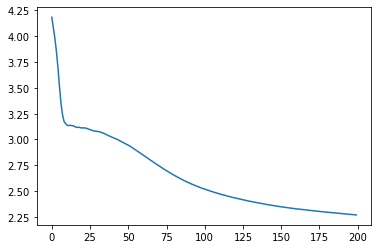

In [58]:
plt.plot(loss_ary)